In [1]:
import os
import h5py
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score

In [2]:
from functions import (hs_generator_test, plot_regression, 
                       predictions_per_plot)

After we import the useful libraries and functions, we load tha dataset and define which model to use (Spatial for this example).

In [3]:
print('\nSHAP EXPLAINER')
gt='moisture'
pixels_per_sample=100
das=None # we use all dates
#train_model='LSTM'
train_model='SPATIAL'
avg=True
box_size=20

#%%
#Define main directories
main_dir='/your/directory'
data_dir=os.path.join(main_dir,'data_hs')
saving_dir=os.path.join(main_dir,'results',gt,'AZURE',train_model)
string_dir='mkdir -p '+saving_dir
os.system(string_dir)

#%%
#Load data and labels
file_name_h5=os.path.join(data_dir,'NUE_canola_hsi_dataset.hdf5')
h5f=h5py.File(file_name_h5,'r')

print('\nOpening dataset...')

print('\nGeneral information about the dataset:')
for i in h5f.attrs.keys():
      print('{} => {}'.format(i, h5f.attrs[i]))

print('\nGroups contained in dataset:')
for key in h5f.keys():
    print(key)


SHAP EXPLAINER

Opening dataset...

General information about the dataset:
creator => Julio Torres-Tello
institution => University of Saskatchewan
year => 2020
crop => canola
bands => 400-1000nm
scanner => Corning microHSI SHARK

Groups contained in dataset:
03092019_DAS95
09092019_DAS101
16082019_DAS77
16092019_DAS108
20082019_DAS81
25092019_DAS117
27082019_DAS88
30082019_DAS91


Then, we create the data generators to feed the model and load the trained model.

In [4]:
#Data generators
dim=3
if avg==True:
    average='True'
else:
    average='False'
        
test_gen_plot=hs_generator_test(h5f, gt,
                            pixels_per_sample=pixels_per_sample, average=average,
                            dim=dim,full_sample=True, das=das)

test_gen_plot_sc=hs_generator_test(h5f, gt,
                           pixels_per_sample=pixels_per_sample, average=average,
                           dim=dim, das=das, full_sample=True, scaled=True, box_size=box_size)
#%%
#Load model
model_file=os.path.join(saving_dir,'model_'+train_model.lower()+'.h5')
model=load_model(model_file)
print('Trained model:')
model.summary()

Trained model:
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_spatial (InputLayer)   [(None, 20, 20, 150)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 20, 20, 3)         453       
_________________________________________________________________
model (Model)                multiple                  1735488   
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 120)               123000    
_________________________________________________________________
dense_1 (Dense)              (None, 84)                10164     
_________________________________________________________________
dense_2 (Dense)              (None, 1)      

Now, we choose a sample to create the explanations.

In [5]:
#%%
#Generate dataset for explanations
generator=test_gen_plot_sc
background=next(generator)[0]

print('\nBackground dataset of size: ', background.shape)


Loading group:  03092019_DAS95

Test set. Loading HS image from plot:  401
moisture => 66.2097326936258

Background dataset of size:  (70, 20, 20, 150)


In [6]:
#Shap
# init the JS visualization code
shap.initjs()

#Obtain shap values for a model
explainer=shap.DeepExplainer(model,background)

Finally, we can plot some samples.

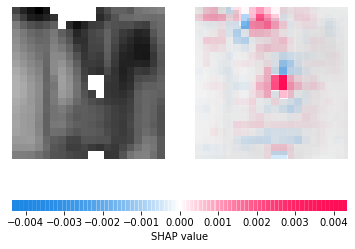

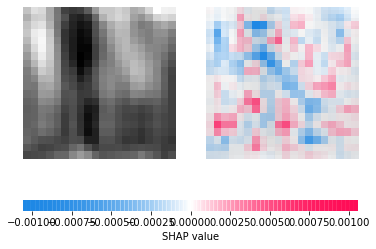

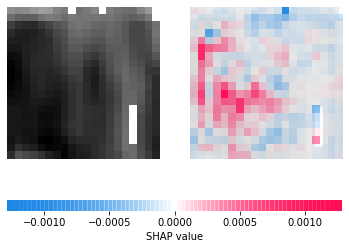

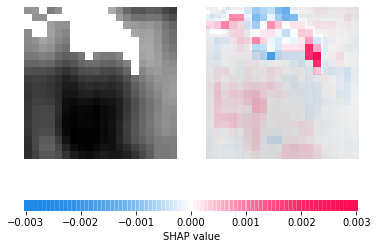

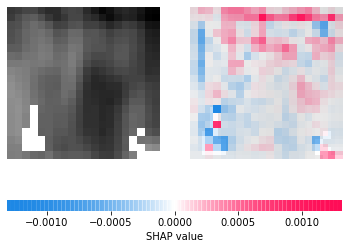

In [23]:
for box in range(20,25):#background.shape[0]):
    X=background[box]
    X=X.reshape(1,20,20,150)
    shap_v=explainer.shap_values(X)
    X_gray=np.mean(X,axis=-1)
    shap_v_gray=np.mean(shap_v[0],axis=-1)
    shap.image_plot(shap_v_gray, -X_gray)
